In [1]:
import pandas_datareader as pdr
import datetime 
aapl = pdr.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2015, 1, 1), 
                          end=datetime.datetime(2020, 8, 24))

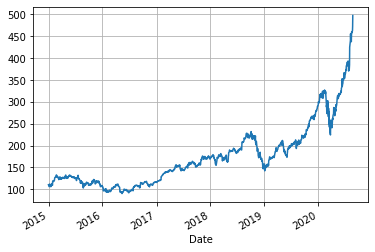

In [2]:
import matplotlib.pyplot as plt

# Plot the closing prices for `aapl`
aapl['Close'].plot(grid=True)

# Show the plot
plt.show()

In [3]:
# Import `numpy` as `np`
import numpy as np

# Assign `Adj Close` to `daily_close`
daily_close = aapl[['Adj Close']]

# Daily returns
daily_pct_change = daily_close.pct_change()

# Replace NA values with 0
daily_pct_change.fillna(0, inplace=True)

# Inspect daily returns
print(daily_pct_change)

# Daily log returns
daily_log_returns = np.log(daily_close.pct_change()+1)

# Print daily log returns
print(daily_log_returns)

            Adj Close
Date                 
2014-12-31   0.000000
2015-01-02  -0.009513
2015-01-05  -0.028172
2015-01-06   0.000094
2015-01-07   0.014022
...               ...
2020-08-17  -0.002611
2020-08-18   0.008333
2020-08-19   0.001255
2020-08-20   0.022190
2020-08-21   0.051532

[1421 rows x 1 columns]
            Adj Close
Date                 
2014-12-31        NaN
2015-01-02  -0.009558
2015-01-05  -0.028576
2015-01-06   0.000094
2015-01-07   0.013925
...               ...
2020-08-17  -0.002614
2020-08-18   0.008298
2020-08-19   0.001254
2020-08-20   0.021947
2020-08-21   0.050249

[1421 rows x 1 columns]


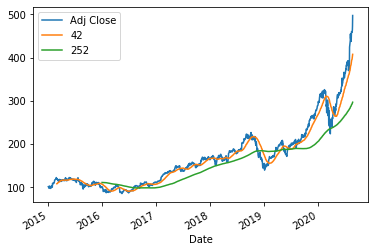

In [4]:
# Short moving window rolling mean
adj_close_px = aapl['Adj Close']
aapl['42'] = adj_close_px.rolling(window=40).mean()

# Long moving window rolling mean
aapl['252'] = adj_close_px.rolling(window=252).mean()

# Plot the adjusted closing price, the short and long windows of rolling means
aapl[['Adj Close', '42', '252']].plot()

# Show plot

plt.show()

In [12]:
import pandas as pd
short_window = 40
long_window = 252

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals)

            signal  short_mavg   long_mavg  positions
Date                                                 
2014-12-31     0.0  110.379997  110.379997        NaN
2015-01-02     0.0  109.855000  109.855000        0.0
2015-01-05     0.0  108.653333  108.653333        0.0
2015-01-06     0.0  108.055000  108.055000        0.0
2015-01-07     0.0  107.994000  107.994000        0.0
...            ...         ...         ...        ...
2020-08-17     1.0  396.840250  293.730674        0.0
2020-08-18     1.0  399.424750  294.730277        0.0
2020-08-19     1.0  401.832249  295.732142        0.0
2020-08-20     1.0  404.658250  296.765714        0.0
2020-08-21     1.0  407.974250  297.896745        0.0

[1421 rows x 4 columns]


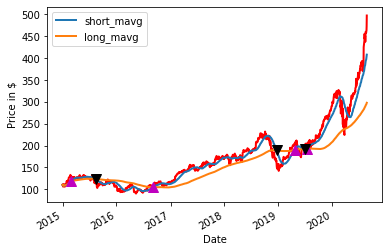

In [13]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

In [17]:
signals.short_mavg[signals.positions == 1.0]

Date
2015-03-02    118.128250
2016-09-07    105.113000
2019-04-25    190.589500
2019-07-16    192.790751
Name: short_mavg, dtype: float64

In [29]:
positions.loc[positions['AAPL'] != 0.0]

,AAPL
Date,
2014-12-31,NaN
2015-03-02,100.0
2015-08-12,-100.0
2016-09-07,100.0
2018-12-19,-100.0
2019-04-25,100.0
2019-06-27,-100.0
2019-07-16,100.0


Date
2014-12-31    NaN
2015-01-02    0.0
2015-01-05    0.0
2015-01-06    0.0
2015-01-07    0.0
             ... 
2020-08-17    0.0
2020-08-18    0.0
2020-08-19    0.0
2020-08-20    0.0
2020-08-21    0.0
Name: positions, Length: 1421, dtype: float64

In [27]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['positions']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(aapl['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(aapl['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio)

            AAPL  holdings           cash          total  returns
Date                                                             
2014-12-31   NaN       0.0  100000.000000  100000.000000      NaN
2015-01-02   0.0       0.0  100000.000000  100000.000000      0.0
2015-01-05   0.0       0.0  100000.000000  100000.000000      0.0
2015-01-06   0.0       0.0  100000.000000  100000.000000      0.0
2015-01-07   0.0       0.0  100000.000000  100000.000000      0.0
...          ...       ...            ...            ...      ...
2020-08-17   0.0       0.0  100132.035065  100132.035065      0.0
2020-08-18   0.0       0.0  100132.035065  100132.035065      0.0
2020-08-19   0.0       0.0  100132.035065  100132.035065      0.0
2020-08-20   0.0       0.0  100132.035065  100132.035065      0.0
2020-08-21   0.0       0.0  100132.035065  100132.035065      0.0

[1421 rows x 5 columns]


In [31]:
pos_diff.loc[pos_diff['AAPL'] != 0.0]

,AAPL
Date,
2014-12-31,NaN
2015-01-02,NaN
2015-03-02,100.0
2015-03-03,-100.0
2015-08-12,-100.0
2015-08-13,100.0
2016-09-07,100.0
2016-09-08,-100.0
2018-12-19,-100.0
